## Effect of the step-size on the integration of an ODE
This work and the following one is based on the points II and III of the paper _Stability of planetary systems: a numerical didactic approach_ by Pakter and Levin.

In this first part the computational accuracy of the Euler's method for solving an ODE is analyzed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d


In this first part the algorithm used is the classic Euler's fistr order method: given an ODE of the type $\mathbf{\dot y}(t)=\mathbf{f}(t, \mathbf{x})$, the integrator solves $$ \mathbf{y}(t+\Delta t) = \mathbf{f}(t, \mathbf{y}(t))\Delta t  $$
In this case, the bodies are subjected to the mutual gravitational attraction, so 
\begin{cases}
  \mathbf{\dot r}_{1,2} = \mathbf{v}_{1,2} \\
  \mathbf{\dot v}_{1,2} = \pm GM \frac{\mathbf{r}_{12}}{r^3_{12}}
\end{cases}
 
The initial conditions are $(x_1,y_1)=(-10,-0.5)m$,   $(x_2,y_2)=(10,0.5)m$, $v_{x1}=1 \frac{m}{s}$, $v_{x2}=-1 \frac{m}{s}$, $v_{y1}=v_{y2}=0\frac{m}{s}$, with $M= 1.5\cdot 10^{10} kg$, $GM=1\frac{m^3}{s^2}$.

In [2]:
def two_body_ODE(t ,y, GM):
  #Dividing y in positions and velocities
  r1, r2  = y[0:2], y[2:4]  #The first four variables are positions
  v1, v2 = y[4:6], y[6:8]  #The next four are velocities
  #Calculating the accelerations
  r_12 = r2-r1
  r3 = np.linalg.norm(r_12)**3
  #With concatenate I concatenate vectors side by side to get the state vector
  return np.array(np.concatenate((v1, v2, GM/r3*r_12, -GM/r3*r_12), axis=None))


In [3]:
def Euler(f, y0, t_span, step=0.1, args=None):
  t0, tf = t_span[0], t_span[1]
  Y = [y0]
  T = [t0]
  t= t0
  
  while t < tf:
    
    y = np.array(Y[-1])
    y = y + step*f(t,y, *args)
    t  = t + step

    Y.append(y)
    T.append(t)

  return T, np.array(Y).T


In [4]:
GM = 1.0
m = 1.5e10
#Initial positions and velocities 
r1 = np.array([-10,-0.5])
r2 = np.array([10, 0.5])
v1 = np.array([1,0])
v2 = np.array([-1,0])

t0, tf = 0, 20

# Getting the modified state vector
y0 = np.concatenate((r1, r2, v1, v2), axis=None)


T1, Y1 = Euler(two_body_ODE, y0=y0, t_span=(t0, tf), step=0.5, args=(GM,))
T2, Y2 = Euler(two_body_ODE, y0=y0, t_span=(t0, tf), step=0.1, args=(GM,))


In [5]:
def E(y):
  r1, r2  = y[0:2], y[2:4]  
  v1, v2 = y[4:6], y[6:8] 
  return 0.5*m*np.sum(v1**2, axis=0)+0.5*m*np.sum(v2**2, axis=0)-GM*m/np.linalg.norm(r1-r2, axis=0)


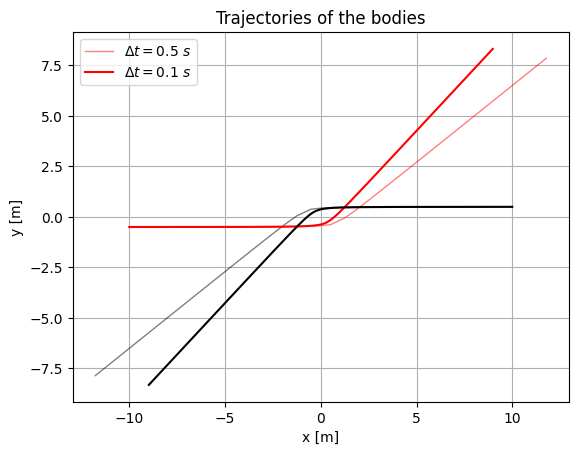

In [6]:
E1 = E(Y1)
x1, y1, x2, y2, = Y1[0], Y1[1], Y1[2], Y1[3]

plt.plot(x1,y1,'r', lw=1, alpha=0.5, label =f'$\Delta t = 0.5$ $s$')
plt.plot(x2,y2,'k', lw=1, alpha=0.5)

E2 = E(Y2)
x1, y1, x2, y2, = Y2[0], Y2[1], Y2[2], Y2[3]
plt.plot(x1,y1,'r', label =f'$\Delta t = 0.1$ $s$')
plt.plot(x2,y2,'k')

plt.title('Trajectories of the bodies')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()
plt.grid()


From the plot is clear how changing the integration step leads to different orbits. The thin lines are the solutions for $\Delta t=0.5s$, the others for $\Delta t=0.1s$.

In the following plot the energy of the system is calculated using $$E = \frac{Mv_1^2}{2}+\frac{Mv_2^2}{2}-\frac{GM^2}{r_{12}} $$

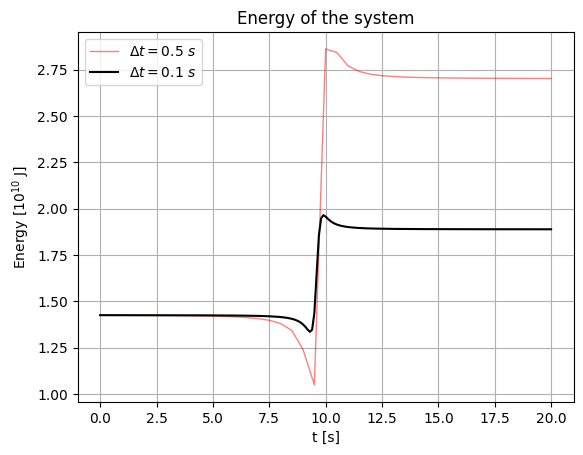

In [17]:
energy_unit = 1e10

plt.title('Energy of the system')
plt.grid()
plt.plot(T1,E1/energy_unit, 'r', lw=1, alpha=0.5, label =f'$\Delta t = 0.5$ $s$')
plt.plot(T2,E2/energy_unit, 'k',label =f'$\Delta t = 0.1$ $s$')
plt.xlabel('t [s]')
plt.ylabel('Energy [$10^{10} $ J]')
plt.legend()


As expected, the energy is not stable and in both cases there is an increase after a sudden spike at $t=10$ $s$ that correspond to the close encounter, and the integration done with a smaller timestep is has a smaller energy error. In comparison to the paper, the spikes have a different form and the final difference is bigger. 

## Investigating the relative energy error

In [8]:
def energy_error(y):
  return np.abs(E(y[:,-1])/E(y[:,0])-1.0)


In [9]:

steps = np.linspace(0.0001,1,100)
errors = []

for step in steps:
  _, y = Euler(two_body_ODE, y0=y0, t_span=(t0, tf), step=step, args=(GM,))
  errors.append(energy_error(y))


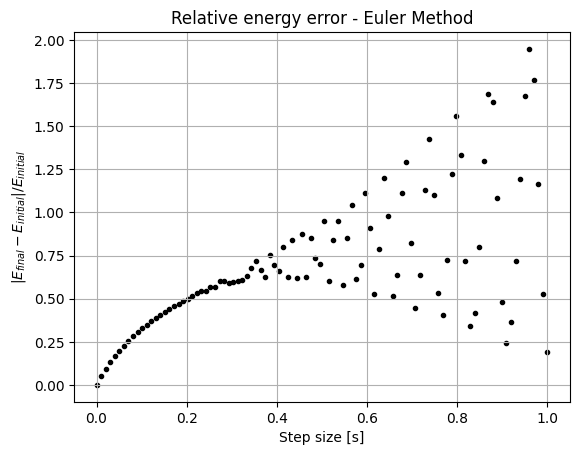

In [10]:
errors = np.array(errors)
plt.xlabel('Step size [s]')
plt.ylabel('$|E_{final}-E_{initial}|/E_{initial}$')
plt.title('Relative energy error - Euler Method')
plt.scatter(steps[errors<5], errors[errors<5], color='k', marker = '.')
plt.grid()


Like in the paper, after a certain step size ($\approx 0.4$ s) the error becomes random. A few points had relative errors over 10 and are not shown in the plot. Differently from the results in the paper, with the Euler method the error does not quickly approach zero but decrease following a different path. A more similar result was found by using the 4-th order Runge-Kutta method, as shown in the following plot.

In [11]:
steps = np.linspace(0.0001,1,100)
errors = []

for step in steps:
  Y = solve_ivp(two_body_ODE, y0=y0, t_span=(t0, tf), max_step=step, atol=1, rtol=1, args=(GM,))
  errors.append(energy_error(Y.y))


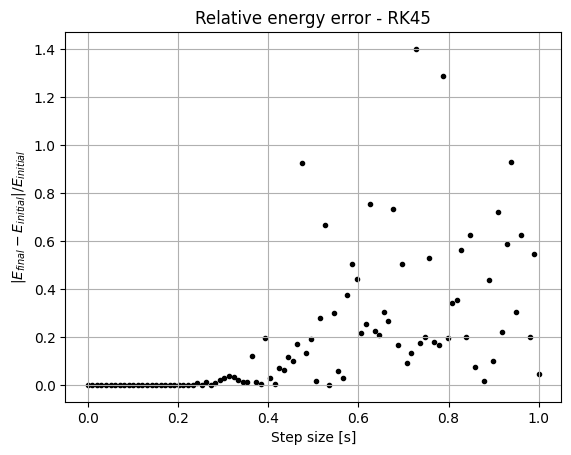

In [12]:
errors = np.array(errors)
plt.xlabel('Step size [s]')
plt.ylabel('$|E_{final}-E_{initial}|/E_{initial}$')
plt.title('Relative energy error - RK45')
plt.scatter(steps[errors<5], errors[errors<5], color='k', marker = '.')
plt.grid()


In [13]:
steps = np.logspace(-5.5, -0.5, 100)
errors = []

for step in steps:
  _, y = Euler(two_body_ODE, y0=y0, t_span=(t0, tf), step=step, args=(GM,))
  errors.append(energy_error(y))


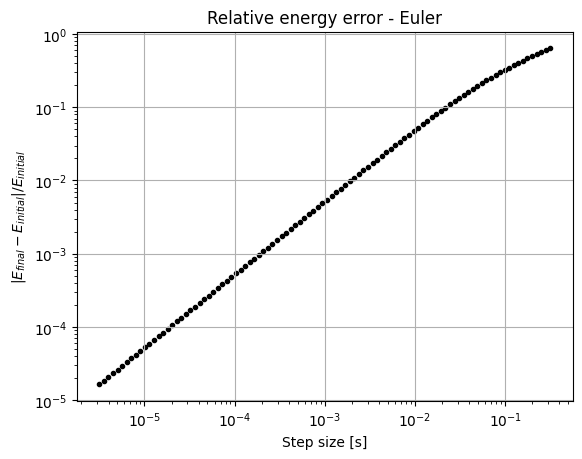

In [14]:
errors = np.array(errors)
plt.xlabel('Step size [s]')
plt.xscale('log')
plt.ylabel('$|E_{final}-E_{initial}|/E_{initial}$')
plt.yscale('log')
plt.title('Relative energy error - Euler')
plt.grid()
plt.scatter(steps[errors<5], errors[errors<5], color='k', marker = '.')


In this logarithmic plot ot the energy error is visible only the nearly constant decrease of the error when snaller step sizes are used. The increase in the error below a certain value due to roundoff errors is not visible, and in general the errors are up to two orders of magnitude bigger than the ones in the paper.
 
 The increase due to round-off errors when the step is too little is not shown. It is possible that such a patter will appear with smaller step sizes, but this would have require a much more intensive computation and/or an improvement of the methods, i.e using just-in-time compilation.
